In [1]:
import pandas as pd

In [2]:
import dask.dataframe as dd

# Load datasets using Dask
logon_data = dd.read_csv("C:/Users/myaka/Desktop/Final_Year_project/data/logon.csv")
file_access_data = dd.read_csv("C:/Users/myaka/Desktop/Final_Year_project/data/file.csv")
email_data = dd.read_csv("C:/Users/myaka/Desktop/Final_Year_project/data/email.csv")
device_data = dd.read_csv("C:/Users/myaka/Desktop/Final_Year_project/data/device.csv")

# Process HTTP data in chunks and save incrementally
input_file = "C:/Users/myaka/Desktop/Final_Year_project/data/http.csv"
output_file = "C:/Users/myaka/Desktop/Final_Year_project/data/http_processed.csv"
columns_needed = ["activity", "id", "url","user"]  # Replace with actual column names

http_data = dd.read_csv(input_file, usecols=columns_needed)


# Aggregate features using Dask




In [3]:
print(logon_data.head())
print(file_access_data.head())
print(email_data.head())
print(device_data.head())
print(http_data.head())

                         id                 date     user       pc activity
0  {F3X8-Y2GT43DR-4906OHBL}  01/02/2010 02:19:18  DNS1758  PC-0414    Logon
1  {B4Q0-D0GM24KN-3704MAII}  01/02/2010 02:31:12  DNS1758  PC-0414   Logoff
2  {T7J1-D4HK34KV-5476TCIJ}  01/02/2010 02:34:02  DNS1758  PC-5313    Logon
3  {S4Y6-D8MQ05SA-0759HLIS}  01/02/2010 02:53:30  DNS1758  PC-5313   Logoff
4  {F3P0-E7FH78CV-4874FRGZ}  01/02/2010 04:07:31  DNS1758  PC-0012    Logon
                         id                 date     user       pc  \
0  {F3E2-X3MV05YQ-3516SZDT}  01/02/2010 07:19:41  SDH2394  PC-5849   
1  {I6N1-Z7VL92UY-8715ESKQ}  01/02/2010 07:21:30  SDH2394  PC-5849   
2  {G4X5-J7MH70FV-8936QVSB}  01/02/2010 07:22:11  SDH2394  PC-5849   
3  {M2M7-Z5ST21EU-6704NSKO}  01/02/2010 07:24:06  SDH2394  PC-5849   
4  {R0A9-O9XB25PE-9236MALV}  01/02/2010 07:24:45  SDH2394  PC-5849   

                  filename    activity  to_removable_media  \
0          R:\60WBQE7S.doc   File Open               False   

In [6]:
# Drop duplicates if any
logon_data = logon_data.drop_duplicates()
file_access_data = file_access_data.drop_duplicates()
email_data = email_data.drop_duplicates()
device_data = device_data.drop_duplicates()
http_data = http_data.drop_duplicates()

# Fill missing values
file_access_data = file_access_data.fillna("")
email_data = email_data.fillna("")
device_data = device_data.fillna("")

In [7]:
import dask.dataframe as dd
import pandas as pd

# Load logon dataset using Dask


# Ensure 'date' column is datetime type
logon_data["date"] = dd.to_datetime(logon_data["date"])

# Convert 'user' and 'activity' to string
logon_data["user"] = logon_data["user"].astype(str)
logon_data["activity"] = logon_data["activity"].astype(str)

# Feature Engineering
logon_features = logon_data.groupby("user").agg({
    "date": ["count", "min", "max"]  # Total logins, first and last logon time
}).reset_index()

# Rename columns
logon_features.columns = ["user", "login_count", "first_logon", "last_logon"]

# 🔹 Convert 'first_logon' and 'last_logon' to datetime explicitly
logon_features["first_logon"] = dd.to_datetime(logon_features["first_logon"])
logon_features["last_logon"] = dd.to_datetime(logon_features["last_logon"])

# 🔹 Calculate logon duration in seconds
logon_features["logon_duration"] = (logon_features["last_logon"] - logon_features["first_logon"]).dt.total_seconds()

# Compute the Dask DataFrame
logon_features = logon_features.compute()

print(logon_features.head())


      user  login_count         first_logon          last_logon  \
0  DNS1758         4104 2010-01-02 02:19:18 2011-05-31 21:08:15   
1  ANC1950          932 2010-01-02 06:16:00 2011-05-31 17:43:00   
2  LAF2213         1728 2010-01-02 06:45:00 2011-06-01 03:45:44   
3  ROR3483         1000 2010-01-02 06:46:00 2011-05-31 18:00:00   
4  SDH2394         1192 2010-01-02 06:49:00 2011-05-31 18:03:00   

   logon_duration  
0      44477337.0  
1      44450820.0  
2      44485244.0  
3      44450040.0  
4      44450040.0  


In [11]:
import numpy as np
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt

# Select relevant numerical features for training
features = logon_features[["login_count", "logon_duration"]]

# Fill any missing values with 0 (important for Isolation Forest)
features = features.fillna(0)

# Initialize Isolation Forest
iso_forest = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)

# Train the model
iso_forest.fit(features)

# Predict anomalies (-1 = anomaly, 1 = normal)
logon_features["anomaly"] = iso_forest.predict(features)

# Map anomalies to a readable format
logon_features["anomaly"] = logon_features["anomaly"].map({1: "Normal", -1: "Anomaly"})

# Show detected anomalies
print(logon_features[logon_features["anomaly"] == "Anomaly"])


         user  login_count         first_logon          last_logon  \
0     DNS1758         4104 2010-01-02 02:19:18 2011-05-31 21:08:15   
32    LAN1329          473 2010-01-02 07:52:00 2010-06-27 16:06:00   
53    DPM2971          127 2010-01-02 08:13:00 2010-02-03 16:26:00   
60    WMM0873          105 2010-01-02 08:22:00 2010-02-04 03:38:35   
89    GNB3337          164 2010-01-02 07:45:00 2010-03-03 17:49:00   
...       ...          ...                 ...                 ...   
3821  CKR2586          365 2010-01-04 08:33:00 2010-07-07 18:23:00   
3861  LCT2783          138 2010-01-04 07:52:00 2010-04-09 17:56:00   
3874  JLL1813          256 2010-01-04 08:18:00 2010-07-02 18:35:00   
3904  KEM1208          280 2010-01-04 07:58:00 2010-07-09 17:50:00   
3955  GCM1580           44 2010-01-04 07:46:00 2010-02-02 19:53:00   

      logon_duration  anomaly  
0         44477337.0  Anomaly  
32        15236040.0  Anomaly  
53         2794380.0  Anomaly  
60         2834195.0  Anomaly  

Anomaly Count:
 anomaly
Normal     3800
Anomaly     200
Name: count, dtype: int64


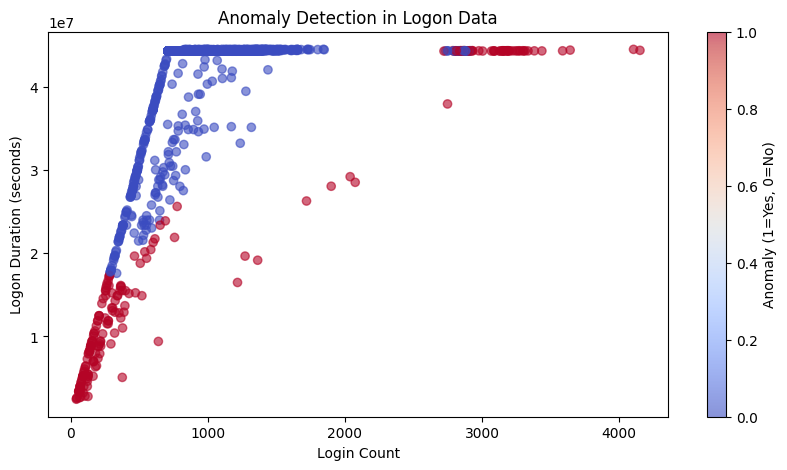

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Count anomalies vs. normal points
anomaly_count = logon_features["anomaly"].value_counts()
print("Anomaly Count:\n", anomaly_count)

# Plot feature distribution with anomalies
plt.figure(figsize=(10, 5))
plt.scatter(logon_features["login_count"], logon_features["logon_duration"], 
            c=(logon_features["anomaly"] == "Anomaly"), cmap="coolwarm", alpha=0.6)
plt.xlabel("Login Count")
plt.ylabel("Logon Duration (seconds)")
plt.title("Anomaly Detection in Logon Data")
plt.colorbar(label="Anomaly (1=Yes, 0=No)")
plt.show()


In [13]:
import pickle

with open("anomaly_logon.pkl", "wb") as model_file:
    pickle.dump(iso_forest, model_file)